In [1]:
import tensorflow as tf
from pathlib import Path
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
fdata = f'../../data/sars-cov2-ct-scan'

p = Path(fdata)
ptrain = p / 'train'
ptest = p / 'test'
pval = p / 'val'

In [4]:
BATCH_SIZE = 10

w, h = (224, 224)

train_generator = ImageDataGenerator(rescale=1. / 255)

val_generator = ImageDataGenerator(rescale=1. / 255)

test_generator = ImageDataGenerator(rescale=1. / 255)

In [5]:
traingen = train_generator.flow_from_directory(ptrain,
                                               target_size=(w, h),
                                               class_mode='binary',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validgen = val_generator.flow_from_directory(pval,
                                               target_size=(w, h),
                                               class_mode='binary',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(ptest,
                                             target_size=(w, h),
                                             class_mode='binary',
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 1788 images belonging to 2 classes.
Found 198 images belonging to 2 classes.
Found 495 images belonging to 2 classes.


In [6]:
traingen.classes

array([0, 0, 0, ..., 1, 1, 1])

In [7]:
traingen.batch_index

0

In [8]:
base_model = keras.applications.VGG19(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(w, h, 3),
    include_top=False)

574710816/574710816 [==============================] - 43s 0us/step


In [12]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
#Freeze the base model
base_model.trainable = True
for layer in base_model.layers[:-1]:
    layer.trainable = False

In [14]:
for layer in base_model.layers:
    print(layer.trainable)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True


In [15]:
inputs = keras.Input(shape=(w, h, 3))
x = base_model(inputs)
x = keras.layers.Flatten()(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(25, activation='relu')(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

In [16]:
foldername = f'models/vgg19a'
save_model = tf.keras.callbacks.ModelCheckpoint(
    filepath=foldername+'/tl-vgg19_model_{epoch:02d}.h5')

save_weight = tf.keras.callbacks.ModelCheckpoint(
    filepath=foldername+'/tl-vgg19_weight_{epoch:02d}.h5',
    save_weights_only=True)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=[keras.metrics.BinaryAccuracy()])
history = model.fit(traingen, epochs=20, validation_data= validgen,
             callbacks=[save_model, save_weight])

Epoch 1/20


ResourceExhaustedError: Graph execution error:

Detected at node 'model/vgg19/block1_conv1/Relu' defined at (most recent call last):
    File "C:\Program Files\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Program Files\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "g:\Ankan\BMI\code\bmifall22\bmifall22venv\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "g:\Ankan\BMI\code\bmifall22\bmifall22venv\lib\site-packages\traitlets\config\application.py", line 982, in launch_instance
      app.start()
    File "g:\Ankan\BMI\code\bmifall22\bmifall22venv\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "g:\Ankan\BMI\code\bmifall22\bmifall22venv\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Program Files\lib\asyncio\base_events.py", line 600, in run_forever
      self._run_once()
    File "C:\Program Files\lib\asyncio\base_events.py", line 1896, in _run_once
      handle._run()
    File "C:\Program Files\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "g:\Ankan\BMI\code\bmifall22\bmifall22venv\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "g:\Ankan\BMI\code\bmifall22\bmifall22venv\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "g:\Ankan\BMI\code\bmifall22\bmifall22venv\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "g:\Ankan\BMI\code\bmifall22\bmifall22venv\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "g:\Ankan\BMI\code\bmifall22\bmifall22venv\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "g:\Ankan\BMI\code\bmifall22\bmifall22venv\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "g:\Ankan\BMI\code\bmifall22\bmifall22venv\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "g:\Ankan\BMI\code\bmifall22\bmifall22venv\lib\site-packages\IPython\core\interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "g:\Ankan\BMI\code\bmifall22\bmifall22venv\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "g:\Ankan\BMI\code\bmifall22\bmifall22venv\lib\site-packages\IPython\core\interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "g:\Ankan\BMI\code\bmifall22\bmifall22venv\lib\site-packages\IPython\core\interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "g:\Ankan\BMI\code\bmifall22\bmifall22venv\lib\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\ankan\AppData\Local\Temp\ipykernel_10292\2559420775.py", line 17, in <module>
      history = model.fit(traingen, epochs=20, validation_data= validgen,
    File "g:\Ankan\BMI\code\bmifall22\bmifall22venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "g:\Ankan\BMI\code\bmifall22\bmifall22venv\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "g:\Ankan\BMI\code\bmifall22\bmifall22venv\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "g:\Ankan\BMI\code\bmifall22\bmifall22venv\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "g:\Ankan\BMI\code\bmifall22\bmifall22venv\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "g:\Ankan\BMI\code\bmifall22\bmifall22venv\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "g:\Ankan\BMI\code\bmifall22\bmifall22venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "g:\Ankan\BMI\code\bmifall22\bmifall22venv\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "g:\Ankan\BMI\code\bmifall22\bmifall22venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "g:\Ankan\BMI\code\bmifall22\bmifall22venv\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "g:\Ankan\BMI\code\bmifall22\bmifall22venv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "g:\Ankan\BMI\code\bmifall22\bmifall22venv\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "g:\Ankan\BMI\code\bmifall22\bmifall22venv\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "g:\Ankan\BMI\code\bmifall22\bmifall22venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "g:\Ankan\BMI\code\bmifall22\bmifall22venv\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "g:\Ankan\BMI\code\bmifall22\bmifall22venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "g:\Ankan\BMI\code\bmifall22\bmifall22venv\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "g:\Ankan\BMI\code\bmifall22\bmifall22venv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "g:\Ankan\BMI\code\bmifall22\bmifall22venv\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "g:\Ankan\BMI\code\bmifall22\bmifall22venv\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "g:\Ankan\BMI\code\bmifall22\bmifall22venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "g:\Ankan\BMI\code\bmifall22\bmifall22venv\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "g:\Ankan\BMI\code\bmifall22\bmifall22venv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "g:\Ankan\BMI\code\bmifall22\bmifall22venv\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "g:\Ankan\BMI\code\bmifall22\bmifall22venv\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "g:\Ankan\BMI\code\bmifall22\bmifall22venv\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'model/vgg19/block1_conv1/Relu'
OOM when allocating tensor with shape[10,224,224,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/vgg19/block1_conv1/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_2207]

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


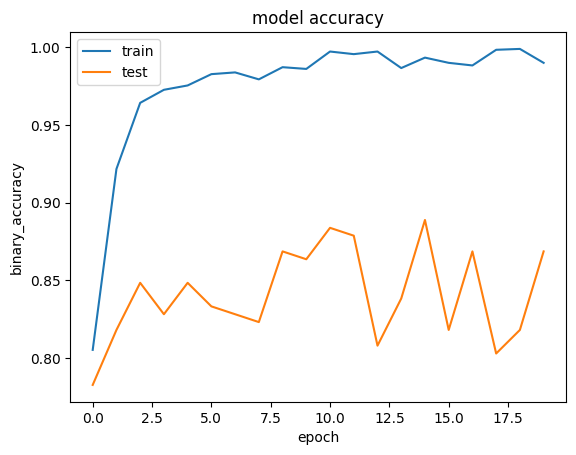

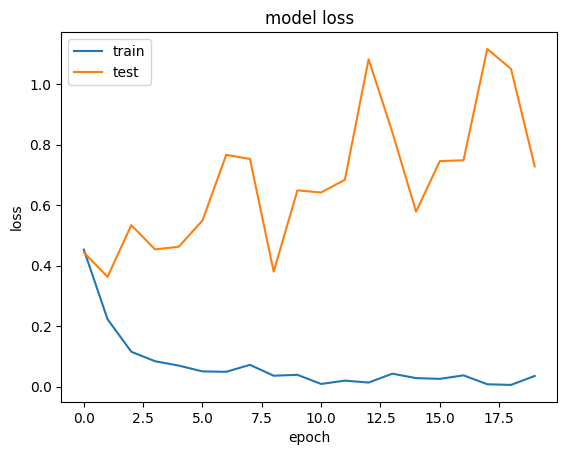

In [ ]:
# list all data in history
print(history.history.keys())

import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
yp=base_model.predict_generator(testgen)
print(yp.shape)

C:\Users\ankan\AppData\Local\Temp\ipykernel_10592\3774926068.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  yp=base_model.predict_generator(testgen)


(495, 7, 7, 512)


In [ ]:
len(testgen.classes)

495

In [24]:
testgen.class_indices

{'COVID': 0, 'non-COVID': 1}

In [55]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

num_of_test_samples = len(testgen.classes)
batch_size = 1
Y_pred = model.predict_generator(testgen, num_of_test_samples // batch_size)
y_pred = [round(i[0]) for i in Y_pred]
print('Confusion Matrix')
print(confusion_matrix(testgen.classes, y_pred))
print('Classification Report')
target_names = ['COVID', 'Non-COVID']
print(classification_report(testgen.classes, y_pred, target_names=target_names))

C:\Users\ankan\AppData\Local\Temp\ipykernel_10592\2839527870.py:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(testgen, num_of_test_samples // batch_size)


Confusion Matrix
[[164  86]
 [ 14 231]]
Classification Report
              precision    recall  f1-score   support

       COVID       0.92      0.66      0.77       250
   Non-COVID       0.73      0.94      0.82       245

    accuracy                           0.80       495
   macro avg       0.83      0.80      0.79       495
weighted avg       0.83      0.80      0.79       495



In [28]:
testgen.image_shape

(224, 224, 3)

In [33]:
testgen.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [42]:
yp=model.predict_generator(testgen, len(testgen.classes))

C:\Users\ankan\AppData\Local\Temp\ipykernel_10592\3400265095.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  yp=model.predict_generator(testgen, len(testgen.classes))


In [43]:
yp.shape

(495, 1)

In [52]:
import math
len([round(i[0]) for i in yp])

495

In [51]:
len(testgen.classes)

495